<a href="https://colab.research.google.com/github/MatheusOrange211/Serie-temporal-covid-19/blob/main/Serie_Temporal_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import zipfile
import requests
from io import BytesIO
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()

#Funções

Os dados estão originalmente salvos no github em extensão `.zip `. Isso porque o arquivo possui mais de 50MB de tamanho. Pensando em facilitar a vida de quem for analisar este projeto, e com a ajuda do [stackOverflow](https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url) (obviamente), criei uma função que realiza uma requisição da URL onde está o meu arquivo, dando um `get`(pegando) os meus dados de lá. Depois com zipfile, eu tento extrair o arquivo, no entanto, por estar pegando de uma for diferente do convencional, meus dados estão comportados de uma forma diferente. Usando  `BytesIo`, eu evito o seguinte erro de entendimento:

```
'bytes' object has no attribute 'seek'
```
Por fim, extraio o arquivo e o retorno. Entretanto, o mesmo não apareça de primeira no seu colab, a não ser que você atualize. Clique no botão com a pastinha e um simbolo de reload. o arquivo agora está lá. Pronto para uso.

In [2]:
def unzip_url_file(url):
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(BytesIO(r.content))
  file = z.extractall()
  return file

Formatando os dados do dataframe Brasil e retornando ele ordenado por data ( do mais antigo até o mais atual ).

In [3]:
def formated_df_brasil(dataset: pd.DataFrame):
  dataset = dataset.drop(columns=["estado","municipio","coduf"],axis=1) #estamos falando do ambito nacional \(°_°)/
  dataset["data"] = pd.to_datetime(dataset['data'],format="%d/%m/%Y")
  dataset["regiao"] = dataset["regiao"].astype(str)
  dataset["populacaoTCU2019"] = dataset["populacaoTCU2019"].astype(int)
  dataset = dataset.sort_values(by="data")
  dataset.reset_index(drop=True,inplace=True)
  return dataset

plotar lineplots simples

In [4]:
def plot_br(data,yaxis, title:str = ""):
  plt.figure(figsize=(15,5))
  ax = sns.lineplot(data=data,x=data.index,y=yaxis)
  plt.title(title)
  return ax;

plotar dois gráficos juntos de forma simples

In [5]:
def plot_graficos_simples(data1, yaxis1,yaxis2,title:str="",lista_legend:list = []):
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data1,x=data1.index,y=yaxis1)
  sns.lineplot(data=data1,x=data1.index,y=yaxis2)
  plt.title(title)
  plt.legend(lista_legend)
  return plt.show()

#Importando Dados

In [6]:
url = "https://github.com/MatheusOrange211/Serie-temporal-covid-19/raw/main/dados/dados_covid_mod_1.zip"


In [7]:
 unzip_url_file(url) #arquivo descompactado e já disponível para uso.
 file_covid = "/content/dados_covid_mod_1.csv"

In [8]:
dados = pd.read_csv(file_covid,sep=";",engine='python')
dados

,regiao,estado,municipio,coduf,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
0,Brasil,NaN,NaN,76,25/02/2020,9,210147125.0,0,0,0,0
1,Brasil,NaN,NaN,76,26/02/2020,9,210147125.0,1,1,0,0
2,Brasil,NaN,NaN,76,27/02/2020,9,210147125.0,1,0,0,0
3,Brasil,NaN,NaN,76,28/02/2020,9,210147125.0,1,0,0,0
4,Brasil,NaN,NaN,76,29/02/2020,9,210147125.0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1048570,Sudeste,SP,Holambra,35,24/09/2020,39,14930.0,346,9,3,0
1048571,Sudeste,SP,Holambra,35,25/09/2020,39,14930.0,347,1,3,0
1048572,Sudeste,SP,Holambra,35,26/09/2020,39,14930.0,352,5,3,0
1048573,Sudeste,SP,Holambra,35,27/09/2020,40,14930.0,352,0,3,0


In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   regiao            1048575 non-null  object 
 1   estado            1048245 non-null  object 
 2   municipio         1034637 non-null  object 
 3   coduf             1048575 non-null  int64  
 4   data              1048575 non-null  object 
 5   semanaEpi         1048575 non-null  int64  
 6   populacaoTCU2019  1043823 non-null  float64
 7   casosAcumulado    1048575 non-null  int64  
 8   casosNovos        1048575 non-null  int64  
 9   obitosAcumulado   1048575 non-null  int64  
 10  obitosNovos       1048575 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 88.0+ MB


Os dados vem diretamente do site do governo federal e vão até a data de 17/01/2021. Pra começar, temos os dados nacionais e dados por estados/Regiões. vou dividir o dataset em dois, analisando de forma mais ampla, vendo todo o País, e olhando depois, por regiões.

In [10]:
dados_brasil = dados.query("regiao == 'Brasil'")
dados_brasil = formated_df_brasil(dados_brasil)
dados_brasil.head()

,regiao,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
0,Brasil,2020-02-25,9,210147125,0,0,0,0
1,Brasil,2020-02-26,9,210147125,1,1,0,0
2,Brasil,2020-02-27,9,210147125,1,0,0,0
3,Brasil,2020-02-28,9,210147125,1,0,0,0
4,Brasil,2020-02-29,9,210147125,2,1,0,0


Criar um dataframe de Série Temporal Para analisar casos novos e óbitos Novos.

In [11]:
br_casos_obitos = dados_brasil[["data","casosNovos","obitosNovos"]].copy()
br_casos_obitos["mes"] = br_casos_obitos["data"].dt.month
br_casos_obitos.set_index('data',inplace=True)

In [12]:
br_casos_obitos.head(5)

,casosNovos,obitosNovos,mes
data,,,
2020-02-25,0,0,2
2020-02-26,1,0,2
2020-02-27,0,0,2
2020-02-28,0,0,2
2020-02-29,1,0,2


#Prevendo Casos Novos - Brasil

temos orignalmente isso

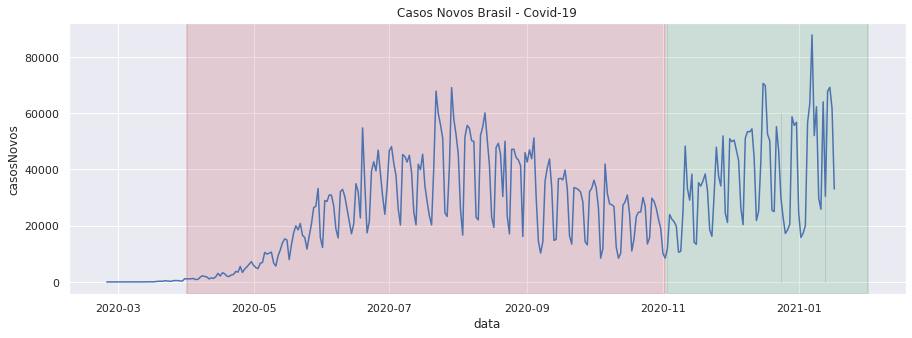

In [13]:
plot_br(br_casos_obitos,"casosNovos",'Casos Novos Brasil - Covid-19')

plt.axvspan(np.datetime64('2020-04-01'),np.datetime64('2020-11-02') ,color='r',linewidth=2,alpha=0.2)
plt.axvspan(np.datetime64('2020-11-03'),np.datetime64('2021-02-01') ,color='g',linewidth=2,alpha=0.2)

Observando os casos novos ao longo dos meses de 2020, temos várias curvas ao longo do ano, começando em 2020-05 (Maio) uma crescente de casos, chegando ao ápice de mais de 60 mil casos entre Julho e Agosto, tendo uma queda, em uma primeira onda, e depois, a partir de novembro, o crescimento da segunda onda com muito mais força, ultrapassando os mais de 80 novos casos diários no início de janeiro de 2021. 
**Observação**: Em vermelho, temos a primeira onda e em verde a segunda onda se configurando.

Algumas informações interessantes a se analisar, como a média móvel, contudo, assim como vemos em jornais, a média móvel dos últimos 7 dias.

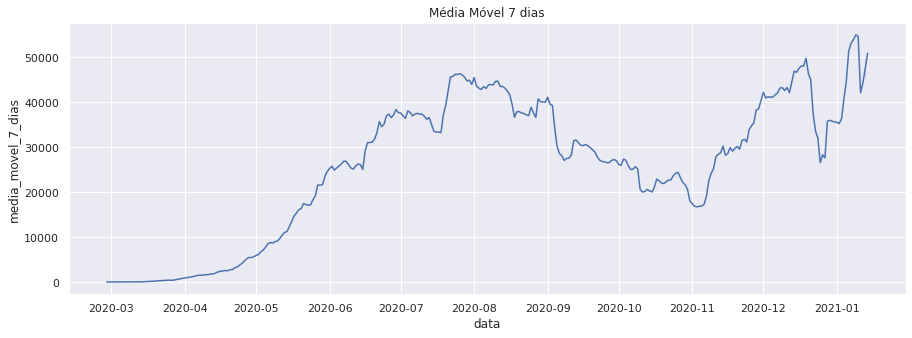

In [14]:
br_casos_obitos["media_movel_7_dias"] = br_casos_obitos["casosNovos"].rolling(window=7,center=True).mean()

plot_br(br_casos_obitos,'media_movel_7_dias','Média Móvel 7 dias')

No fim, o que temos é isso:

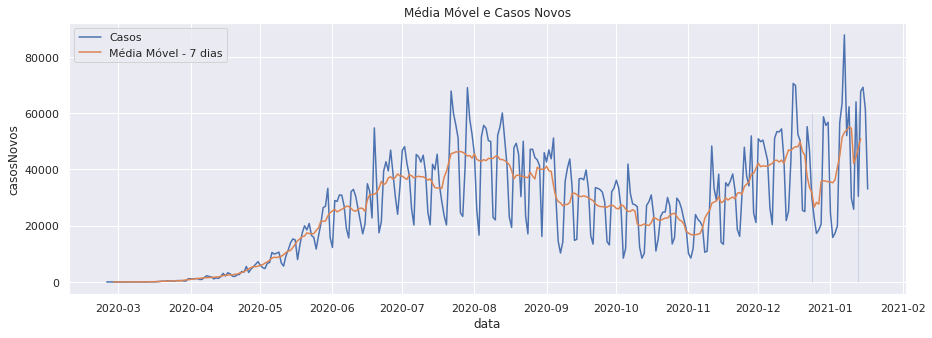

In [15]:
plot_graficos_simples(br_casos_obitos,"casosNovos","media_movel_7_dias",
                      "Média Móvel e Casos Novos",["Casos","Média Móvel - 7 dias"])

Olhando então a configuração das médias móveis, então vamos começar a realizar previsões de buscar prever novos casos.

In [16]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposicao = seasonal_decompose(br_casos_obitos["casosNovos"],freq=18)
# decomposicao.plot();

#Prevendo óbitos Novos - Brasil

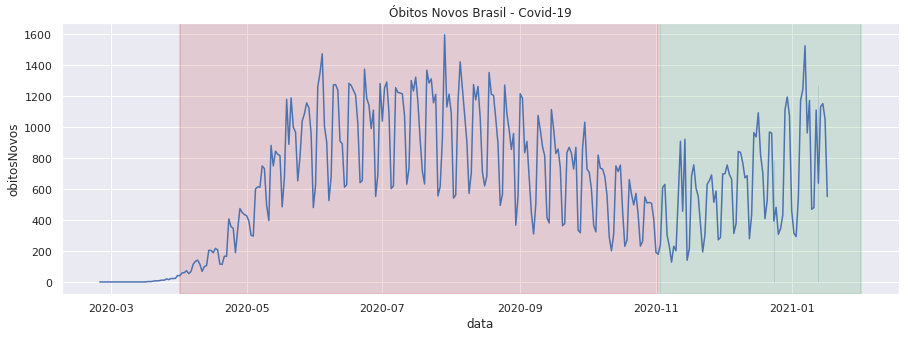

In [17]:
plot_br(br_casos_obitos,"obitosNovos",'Óbitos Novos Brasil - Covid-19')

plt.axvspan(np.datetime64('2020-04-01'),np.datetime64('2020-11-02') ,color='r',linewidth=2,alpha=0.2)
plt.axvspan(np.datetime64('2020-11-03'),np.datetime64('2021-02-01') ,color='g',linewidth=2,alpha=0.2)